<a href="https://colab.research.google.com/github/NajmKHoda/numpy-mnist-classifier/blob/main/numpy-mnist-classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import seaborn as sns
from math import exp, log, sqrt
from random import shuffle

# Mathematical functions

In [ ]:
# The ReLU function
def ReLU(x):
  return np.maximum(x, 0.0)

# The derivative of the ReLU function
def dReLU(x):
  return np.where(x > 0, 1.0, 0.0)

# The sigmoid function
def softmax(x):
  exp = np.exp(x - np.max(x))
  return exp / np.sum(exp)

# Returns a one-hot column vector
def one_hot(x, size):
  vec = np.zeros((size, 1))
  vec[x][0] = 1.0
  return vec

# Obtains a number from a one-hot encoding
def from_one_hot(x):
  return np.argmax(x)

# `NeuralNetwork` class

In [ ]:
class NeuralNetwork:

  def __init__(self, shape):
    # The shape of input features expected by this network.
    self.input_features_shape = (shape[0], 1)

    # The number of layers in this network.
    self.num_layers = len(shape)

    # This neural network's weights and biases.
    # Each element of both arrays represents a single layer.
    self.weights = []
    self.biases = []

    for i, n in enumerate(shape):
      # We don't generate weights/biases for the input (first) layer.
      if i == 0: continue

      # Initialize the bias matrix for this layer to a matrix of 0s.
      layer_biases = np.zeros((n, 1))
      self.biases.append(layer_biases)

      # Initialize the randomized weight matrix for this layer.
      # The weight matrix has size n x m, where:
      #     n is the number of nodes in this layer
      #     m is the number of nodes in the previous layer
      m = shape[i - 1]
      layer_weights = np.random.randn(n, m)
      layer_weights *= sqrt(2/m)
      self.weights.append(layer_weights)

  def forward(self, data, output_layer_only = True):
    # The data represents the activation of the input layer.
    activation = data.copy().reshape(self.input_features_shape);

    # We calculate the activation of successive layers.
    activations = [activation]
    for weight, bias in zip(self.weights[:-1], self.biases[:-1]):
      activation = ReLU(weight @ activation + bias)
      if not output_layer_only:
        activations.append(activation)

    # Apply the softmax function to the last layer.
    z = self.weights[-1] @ activation + self.biases[-1]
    activation = softmax(z)
    activations.append(activation)

    # We now have the activation of the output layer.
    if output_layer_only:
      return activation
    else:
      return activations

  def stochastic_gradient_descent(self, data, learning_rate, batch_size = 10):
    n = len(data)
    shuffle(data)
    batches = [data[i:i+batch_size] for i in range(0, n, batch_size)]
    costs = []

    for batch in batches:
      self.mini_gradient_descent(batch, learning_rate, costs)

    fig, ax = plt.subplots()

    print(f"Last cost: {costs[-1]}")
    ax.plot(costs)
    ax.set_xlabel("Batch")
    ax.set_ylabel("Cost")
    plt.show()

  def mini_gradient_descent(self, batch, learning_rate, costs):
    n = len(batch)

    # The weight and bias components of the gradient
    avg_grad_weight = [np.zeros(weight.shape) for weight in self.weights]
    avg_grad_bias = [np.zeros(bias.shape) for bias in self.biases]
    avg_cost = 0

    # Backpropagate for each image in the batch and add each resulting gradient to our average
    for image, target in batch:
      grad_weight, grad_bias, cost = self.backprop(image, target)
      avg_grad_weight = [dL_dw + dLk_dw for dL_dw, dLk_dw in zip(avg_grad_weight, grad_weight)]
      avg_grad_bias = [dL_db + dLk_db for dL_db, dLk_db in zip(avg_grad_bias, grad_bias)]
      avg_cost += cost

    # Update the weights and biases accordingly
    self.weights = [weight - (learning_rate / n) * grad_weight for weight, grad_weight in zip(self.weights, avg_grad_weight)]
    self.biases = [bias - (learning_rate / n) * grad_bias for bias, grad_bias in zip(self.biases, avg_grad_bias)]

    # Track the costs
    avg_cost /= n
    costs.append(avg_cost)

  def backprop(self, image, target):
    # The weight and bias components of the gradient
    grad_weight = [np.zeros(weight.shape) for weight in self.weights]
    grad_bias = [np.zeros(bias.shape) for bias in self.biases]

    activations = self.forward(image, False)
    a = activations[-1]
    cost = -log(a[target][0] + 1e-20)

    # dL/dz = a - y
    y = one_hot(target, a.size)
    dL_dz = a - y

    # dL/dw = dL/dz @ x.T
    x = activations[-2]
    dL_dw = dL_dz @ x.T

    # Since dz/db = the identity matrix, dL/db = dL/dz
    dL_db = dL_dz

    # Update the gradient
    grad_weight[-1] = dL_dw
    grad_bias[-1] = dL_db

    # dL/dx = W.T @ dL/dz
    W = self.weights[-1]
    dL_dx = W.T @ dL_dz

    # Go through the rest of the layers
    for j in range(-2, -self.num_layers, -1):
      a = activations[j]
      x = activations[j - 1]

      dL_dz = dL_dx * dReLU(a)
      dL_dw = dL_dz @ x.T
      dL_db = dL_dz

      grad_weight[j] = dL_dw
      grad_bias[j] = dL_db

      W = self.weights[j]
      dL_dx = W.T @ dL_dz

    return (grad_weight, grad_bias, cost)


# MNIST Database

Last cost: 0.8173911127909406


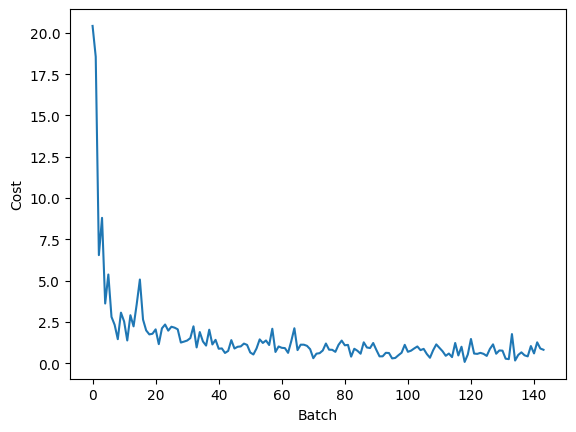

In [ ]:
images, targets = load_digits(return_X_y=True)

data = [(image, target) for image, target in zip(images, targets)]
shuffle(data)
n = len(data)

# Separate the training and testing data (3:1)
k = n * 4 // 5
training_data = data[:k]
testing_data = data[k:]

"""
# We test on 1's alone to debug the model
filter = [0, 1, 2, 3, 4]
training_data = [(image, target) for image, target in data if target in filter]
"""

# Train the network
network = NeuralNetwork((64, 48, 32, 10))
network.stochastic_gradient_descent(training_data, 0.0075, 10)

Accuracy: 0.7611111111111111


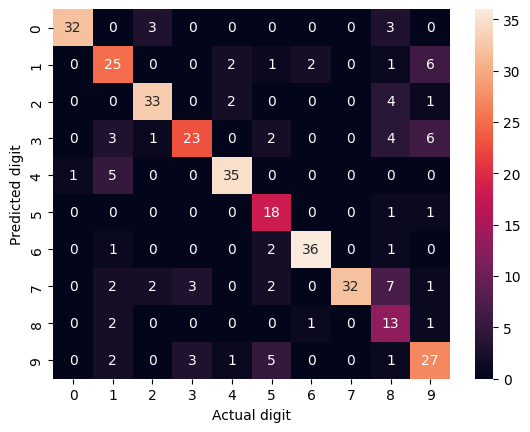

In [ ]:
# Test the network
confusion_matrix = np.zeros((10, 10))
num_correct = 0
for image, target in testing_data:
  output = network.forward(image)
  predicted = from_one_hot(output)
  if predicted == target:
    num_correct += 1
  confusion_matrix[predicted][target] += 1

ax = sns.heatmap(confusion_matrix, annot=True)
ax.set_xlabel("Actual digit")
ax.set_ylabel("Predicted digit")

n = len(testing_data)
accuracy = num_correct / n
print(f"Accuracy: {accuracy}")

In [ ]:
n = int(input())
res = network.forward(images[n])

print("Image")
plt.figure()
plt.imshow(images[n].reshape((8, 8)))

print(res)

10


NameError: name 'network' is not defined